# Análise e Previsão de Vendas de Café com Modelos de Machine Learning

Este notebook se concentra na análise e previsão das vendas de café de uma máquina de vendas automatizada, usando técnicas de Machine Learning para prever as vendas futuras de diferentes tipos de café.

O objetivo deste projeto é explorar um conjunto de dados de vendas de café, que contém informações diárias de transações desde março de 2024 até o momento presente, e criar modelos preditivos para estimar as vendas futuras.

## Compilando dados

Para este projeto, foi utilizado o conjunto de dados de vendas de café fornecido por Yaroslav Isaienkov no Kaggle. O dataset contém registros diários de transações de uma máquina de vendas de café, com dados coletados desde março de 2024 até o presente.

Os dados originais foram baixados diretamente do Kaggle, e o processamento foi feito com o objetivo de preparar os dados para modelos de séries temporais. Para garantir que o conjunto de dados fosse compatível com esses modelos, algumas transformações foram necessárias:

1. **Conversão para Formato Compatível com Séries Temporais**:
   - A coluna de **data** foi convertida para o formato `datetime` utilizando o método `pd.to_datetime()`. Essa conversão é essencial para trabalhar com séries temporais, pois permite a manipulação eficiente das datas.
   
1. **Agregação de Vendas por Mês**:
   - Para adaptar os dados a um formato mais adequado para modelagem preditiva, foi realizada uma agregação das vendas diárias para **vendas mensais**. Isso foi feito utilizando o `groupby` para agrupar os dados por data e tipo de café, seguido do `resample('ME')` para fazer a soma das vendas por mês.
   
1. **Filtragem dos Cafés Mais Populares**:
   - Para focar na análise dos cafés mais vendidos, selecionei os 6 tipos de café com maior volume de vendas, o que ajuda a reduzir a complexidade do modelo e melhora a qualidade das previsões.


Essas etapas garantiram que os dados estivessem no formato adequado para serem utilizados em modelos de séries temporais. O formato final foi uma tabela onde cada linha representa um mês, e cada coluna contém o número de vendas de um tipo de café específico.

### Dataset

This [dataset](https://www.kaggle.com/datasets/ihelon/coffee-sales) contains detailed records of coffee sales from a vending machine.
The vending machine is the work of a dataset author who is committed to providing an open dataset to the community.
It is intended for analysis of purchasing patterns, sales trends, and customer preferences related to coffee products.
Data Collection Period

The dataset spans from March 2024 to Present time, capturing daily transaction data. And new information continues to be added.

> Author: Yaroslav Isaienkov @ihelon

In [2]:
!kaggle datasets download -d "ihelon/coffee-sales"

Dataset URL: https://www.kaggle.com/datasets/ihelon/coffee-sales
License(s): CC0-1.0


In [3]:
!unzip coffee-sales.zip

Archive:  coffee-sales.zip
  inflating: index_1.csv             
  inflating: index_2.csv             


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.concat(map(pd.read_csv, ['index_1.csv', 'index_2.csv']))
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [6]:
df['date'] = pd.to_datetime(df['date'])

df_monthly = (df
  .groupby([df['date'], 'coffee_name'])
  .size()
  .reset_index(name='count')
  .pivot(index='date', columns='coffee_name', values='count')
  .fillna(0)
  .resample('ME').sum())

del df

df_monthly = df_monthly[df_monthly.sum().sort_values(ascending=False).head(6).index]

print(df_monthly.shape)
df_monthly.head()

(13, 6)


coffee_name,Americano with Milk,Latte,Americano,Cappuccino,Cortado,Hot Chocolate
date,,,,,,
2024-03-31,34.0,48.0,36.0,20.0,30.0,22.0
2024-04-30,42.0,31.0,35.0,43.0,19.0,13.0
2024-05-31,58.0,58.0,48.0,55.0,17.0,14.0
2024-06-30,69.0,50.0,14.0,46.0,19.0,14.0
2024-07-31,65.0,56.0,36.0,32.0,14.0,11.0


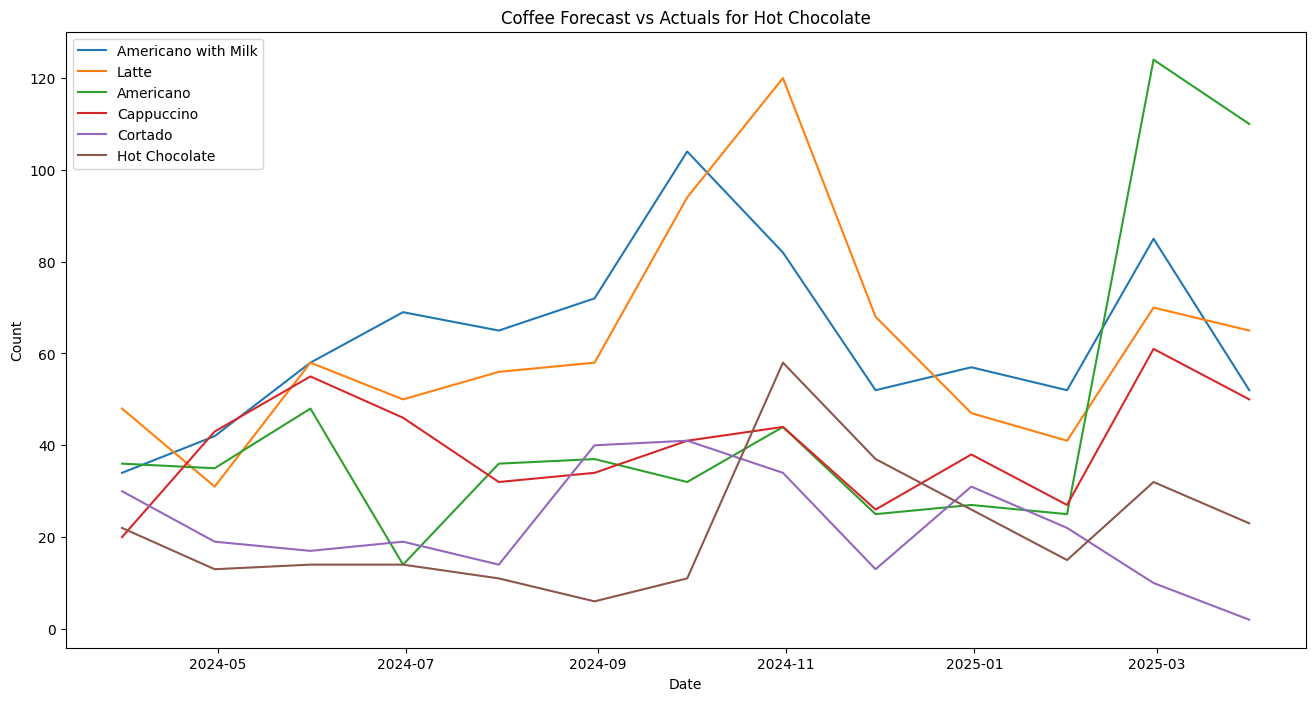

In [7]:
plt.figure(figsize=(16, 8))
for coffee_name in df_monthly.columns:
    plt.plot(df_monthly.index, df_monthly[coffee_name], label=coffee_name)

plt.legend()

plt.xlabel('Date')
plt.ylabel('Count')
plt.title(f'Coffee Forecast vs Actuals for {coffee_name}')

plt.show()

## Usando o modelo Prophet

O Prophet é um modelo de previsão de séries temporais desenvolvido pelo Facebook, projetado para lidar com séries temporais que possuem padrões sazonais e efeitos de feriados, além de permitir a manipulação de dados com lacunas e anomalias. O Prophet é especialmente útil quando os dados apresentam tendências e sazonalidades de longo prazo, o que é comum em muitos problemas de previsão, como vendas, clima e comportamento de usuários.

In [94]:
from prophet import Prophet

In [95]:
forecasts = {}
for coffee_name in df_monthly.columns:
  df_coffee = pd.DataFrame({'ds': df_monthly.index, 'y': df_monthly[coffee_name]})
  m = Prophet()
  m.fit(df_coffee)
  forecasts[coffee_name] = m.predict(m.make_future_dataframe(periods=6, freq='M'))
  del df_coffee

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyaabp6rt/hpd4eonz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyaabp6rt/3n2b9xva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44887', 'data', 'file=/tmp/tmpyaabp6rt/hpd4eonz.json', 'init=/tmp/tmpyaabp6rt/3n2b9xva.json', 'output', 'file=/tmp/tmpyaabp6rt/prophet_model3rike7a9/prophet_model-20250329170854.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:08:54 - cmdstanpy - INFO - Chain [1] start processing
IN

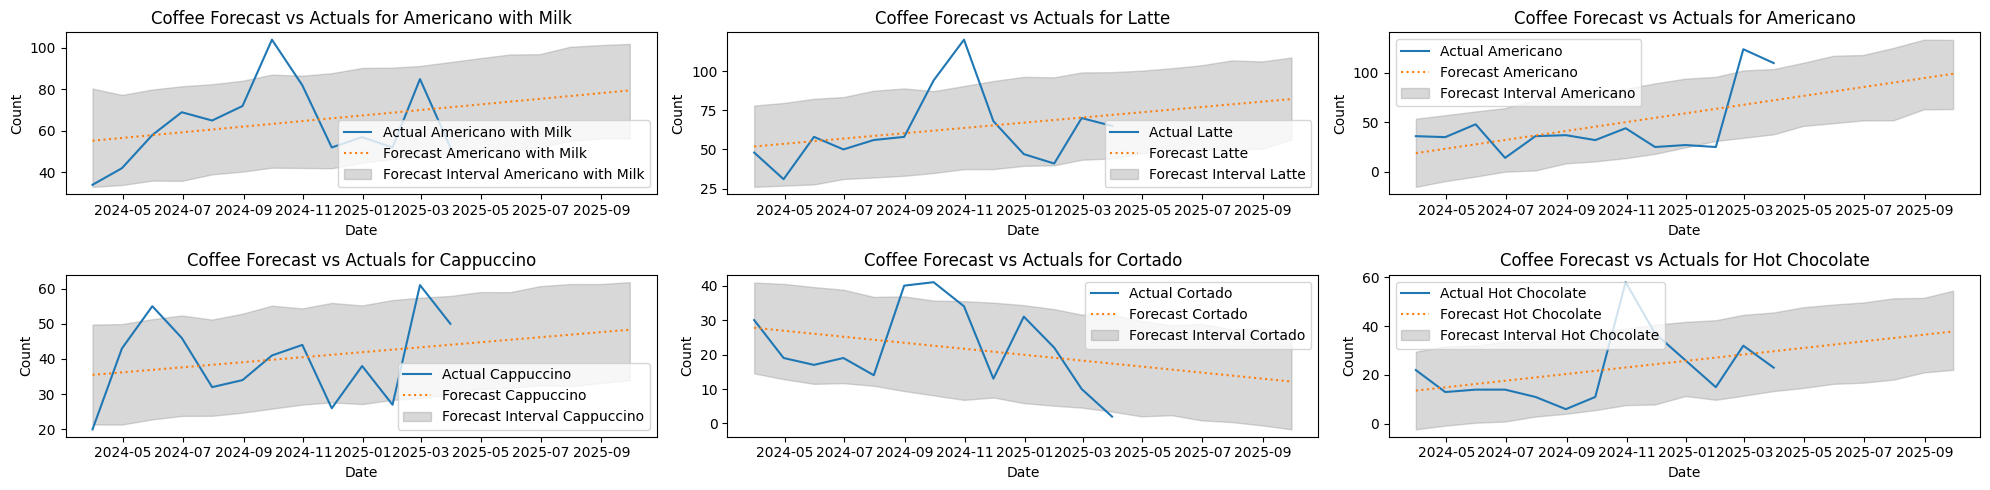

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))

for i, coffee_name in enumerate(df_monthly.columns[:6]):
    ax = axes[i // 3][i % 3]

    ax.plot(df_monthly.index, df_monthly[coffee_name], label=f'Actual {coffee_name}')
    ax.plot(forecasts[coffee_name]['ds'], forecasts[coffee_name]['yhat'], linestyle='dotted', label=f'Forecast {coffee_name}')

    ax.fill_between(forecasts[coffee_name]['ds'], forecasts[coffee_name]['yhat_lower'], forecasts[coffee_name]['yhat_upper'],
                    color='gray', alpha=0.3, label=f'Forecast Interval {coffee_name}')

    ax.legend()

    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(f'Coffee Forecast vs Actuals for {coffee_name}')

plt.tight_layout()

plt.show()

## Modelo de LSTM usando Keras

O LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) projetada para lidar com dados sequenciais, como séries temporais. Diferentemente das RNNs tradicionais, as LSTMs são capazes de aprender dependências de longo prazo, o que as torna ideais para tarefas em que o contexto de eventos passados pode influenciar eventos futuros. Isso é especialmente útil quando lidamos com dados temporais, como vendas de café, onde as tendências passadas podem fornecer informações importantes para prever as vendas futuras.

A métrica de loss utilizada no modelo LSTM (Long Short-Term Memory) foi a "mean squared error" (MSE). O MSE é uma medida que quantifica a diferença entre os valores reais (ou observados) e os valores preditos pelo modelo. Ele é calculado pela média dos quadrados das diferenças entre os valores previstos e os valores reais.

A motivação pela escolha dessa métrica está justamento no fato de que ela é altamente adequada para tarefas de regressão, que é o caso desse problema, onde o objetivo é prever valores contínuos, como as vendas mensais de diferentes tipos de café.



In [8]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
X_train = {}
y_train = {}
X_test = {}
y_test = {}

for coffee_name in df_monthly.columns:
  X = (df_monthly.index - df_monthly.index.min()).days.values.reshape(-1, 1)
  y = df_monthly[coffee_name].values

  X_train[coffee_name], X_test[coffee_name], y_train[coffee_name], y_test[coffee_name] = train_test_split(X, y, test_size=0.3, random_state=42)

  print(f"{coffee_name}:")
  print(f"  X_train: {X_train[coffee_name].shape}")
  print(f"  y_train: {y_train[coffee_name].shape}")
  print(f"  X_test: {X_test[coffee_name].shape}")
  print(f"  y_test: {y_test[coffee_name].shape}\n")

Americano with Milk:
  X_train: (9, 1)
  y_train: (9,)
  X_test: (4, 1)
  y_test: (4,)

Latte:
  X_train: (9, 1)
  y_train: (9,)
  X_test: (4, 1)
  y_test: (4,)

Americano:
  X_train: (9, 1)
  y_train: (9,)
  X_test: (4, 1)
  y_test: (4,)

Cappuccino:
  X_train: (9, 1)
  y_train: (9,)
  X_test: (4, 1)
  y_test: (4,)

Cortado:
  X_train: (9, 1)
  y_train: (9,)
  X_test: (4, 1)
  y_test: (4,)

Hot Chocolate:
  X_train: (9, 1)
  y_train: (9,)
  X_test: (4, 1)
  y_test: (4,)



In [97]:
models = {}

for coffee_name in df_monthly.columns:
  models[coffee_name] = keras.Sequential()
  models[coffee_name].add(keras.layers.Input(shape=(X_train[coffee_name].shape[1], 1)))
  models[coffee_name].add(keras.layers.LSTM(128, return_sequences=True))
  models[coffee_name].add(keras.layers.Dense(1))
  models[coffee_name].compile(loss='mean_squared_error', optimizer='adam')
  print(f"{coffee_name}:")
  print(f"{models[coffee_name].summary()}\n")

Americano with Milk:


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_65 (LSTM)                       │ (None, 1, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Latte:


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                       │ (None, 1, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Americano:


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_67 (LSTM)                       │ (None, 1, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Cappuccino:


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                       │ (None, 1, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Cortado:


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                       │ (None, 1, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Hot Chocolate:


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                       │ (None, 1, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None



In [98]:
h = {}

for coffee_name in df_monthly.columns:
  h[coffee_name] = (models[coffee_name]
                    .fit(X_train[coffee_name],
                         y_train[coffee_name],
                         epochs=900,
                         verbose=0,
                         validation_data=(X_test[coffee_name], y_test[coffee_name])))

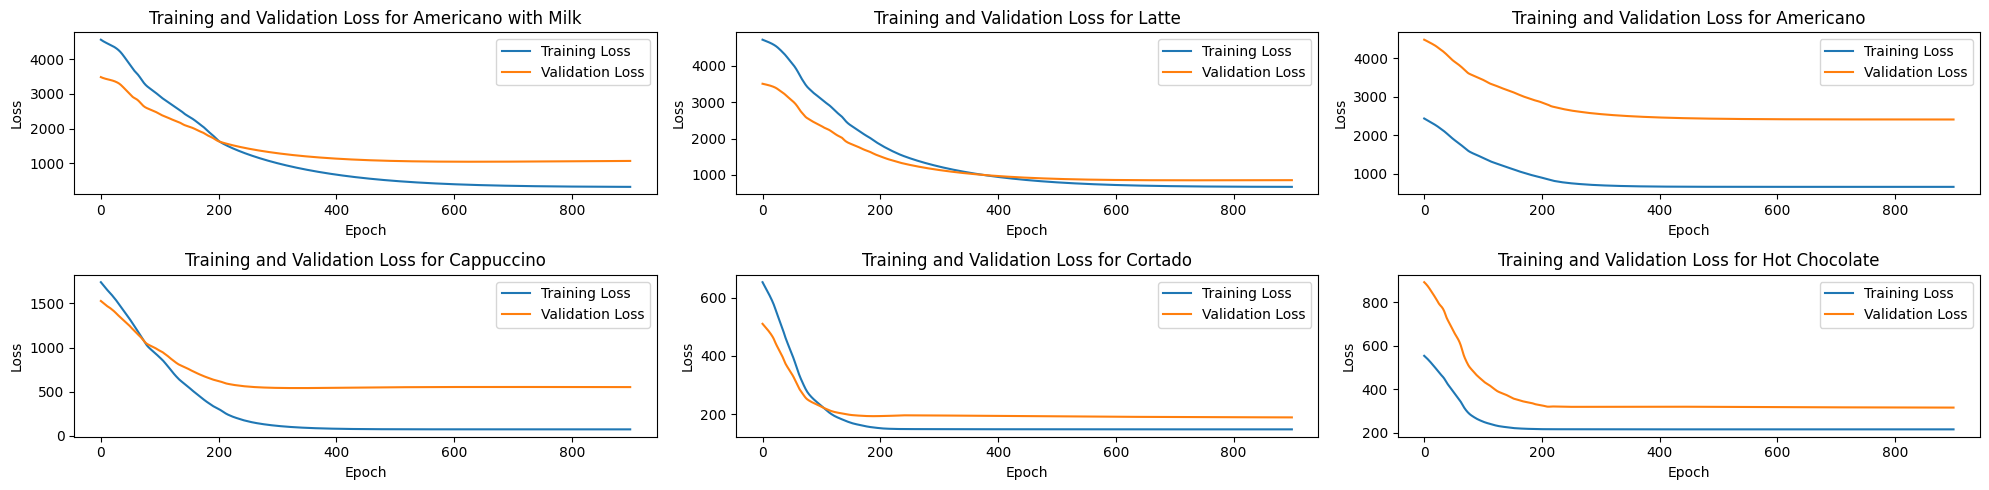

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))

for i, coffee_name in enumerate(df_monthly.columns):
      ax = axes[i // 3][i % 3]
      ax.plot(h[coffee_name].history['loss'], label='Training Loss')
      ax.plot(h[coffee_name].history['val_loss'], label='Validation Loss')
      ax.set_xlabel('Epoch')
      ax.set_ylabel('Loss')
      ax.set_title(f'Training and Validation Loss for {coffee_name}')
      ax.legend()

plt.tight_layout()
plt.show()

In [100]:
future_predictions = {}

for coffee_name in df_monthly.columns:
    predictions = [df_monthly[coffee_name].iloc[0]]

    for i in range(df_monthly[coffee_name].shape[0] + 6):
        input_data = np.array(predictions[-12:]).reshape(1, -1, 1)

        next_prediction = models[coffee_name].predict(input_data, verbose=0)

        predictions.append(next_prediction[0, 0, 0])

    future_predictions[coffee_name] = predictions

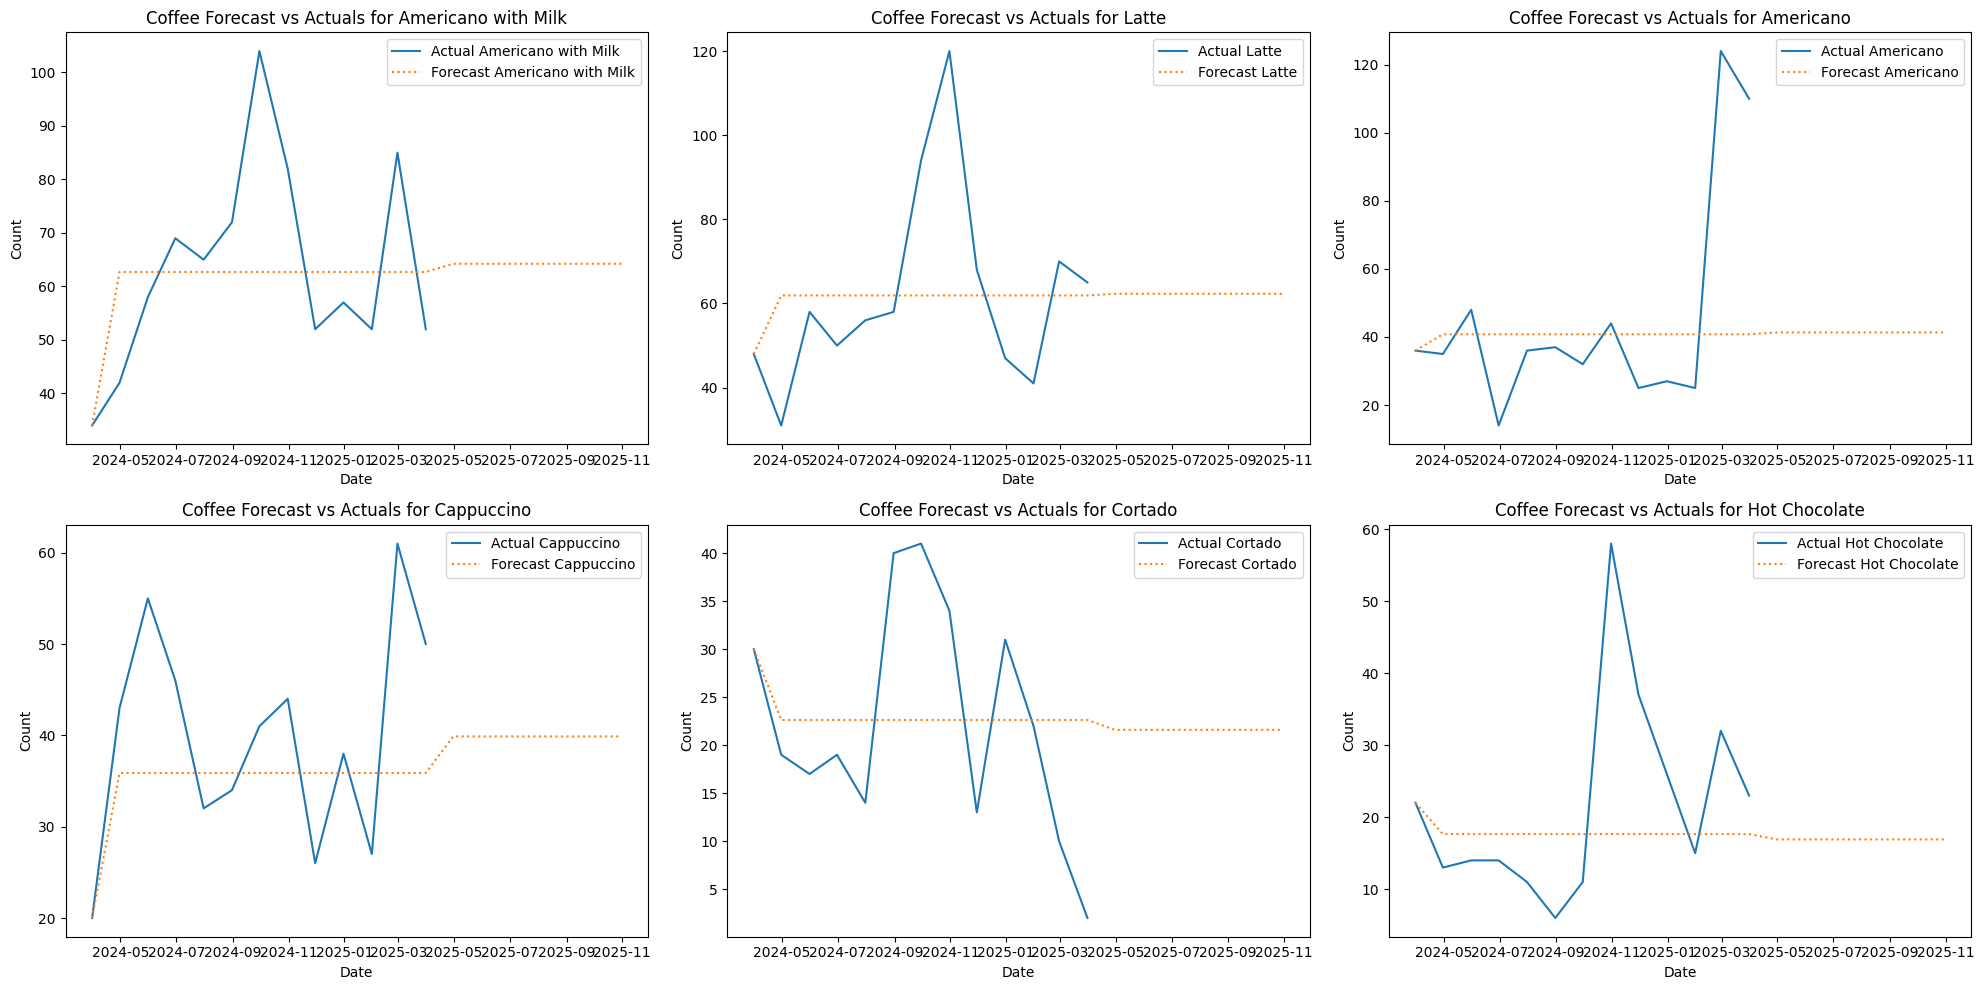

In [101]:
dates = pd.date_range(start=df_monthly.index[0], periods=len(future_predictions[list(future_predictions.keys())[0]]), freq='ME')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i, coffee_name in enumerate(df_monthly.columns):
    ax = axes[i // 3][i % 3]
    ax.plot(df_monthly.index, df_monthly[coffee_name], label=f'Actual {coffee_name}')
    ax.plot(dates, future_predictions[coffee_name], label=f'Forecast {coffee_name}', linestyle='dotted')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(f'Coffee Forecast vs Actuals for {coffee_name}')
    ax.legend()

plt.tight_layout()
plt.show()

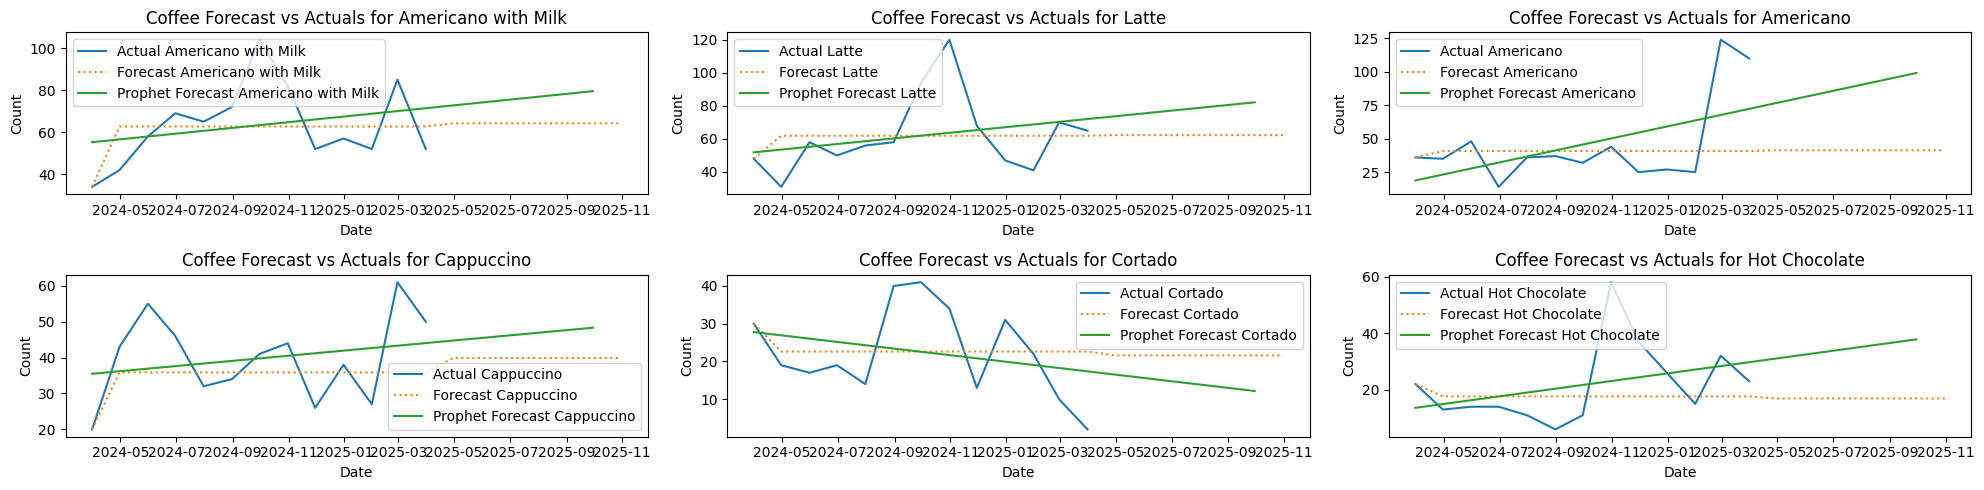

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 5))
for i, coffee_name in enumerate(df_monthly.columns):
    ax = axes[i // 3][i % 3]
    ax.plot(df_monthly.index, df_monthly[coffee_name], label=f'Actual {coffee_name}')
    ax.plot(dates, future_predictions[coffee_name], label=f'Forecast {coffee_name}', linestyle='dotted')
    ax.plot(forecasts[coffee_name]['ds'], forecasts[coffee_name]['yhat'], label=f'Prophet Forecast {coffee_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(f'Coffee Forecast vs Actuals for {coffee_name}')
    ax.legend()

plt.tight_layout()
plt.show()